### Lab2

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1.	Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимый признак и зависимый признак (отклик). Оставьте в наборе признаки, принимающие числовые значения.

In [2]:
data = tfds.load("wine_quality", split='train')
data = tfds.as_dataframe(data)

In [3]:
_1 = 'features/density'
_2 = 'features/alcohol'

In [4]:
data = data[list(set(data.select_dtypes(exclude='object').columns.to_list() + [_1] + [_2]))]
columns_to_keep = [col for col in data.columns if data[col].nunique() > 10]
data = data[columns_to_keep]

In [5]:
data.head()

,features/residual sugar,features/citric acid,features/volatile acidity,features/alcohol,features/total sulfur dioxide,features/pH,features/sulphates,features/fixed acidity,features/free sulfur dioxide,features/density,features/chlorides
0,18.35,0.34,0.32,9.0,197.0,3.22,0.55,7.6,44.0,1.00080,0.054
1,1.20,0.49,0.27,12.2,92.0,3.38,0.42,6.3,35.0,0.99110,0.063
2,1.10,0.11,0.43,11.2,51.0,3.51,0.48,5.3,6.0,0.99076,0.029
3,10.70,0.27,0.41,9.0,103.0,3.08,0.41,6.6,20.0,0.99672,0.110
4,3.80,0.30,0.34,12.0,135.0,3.09,0.34,5.9,57.0,0.99016,0.035


# 2.	Удалите из набора точки с выбросами при помощи стандартизованной оценки (Z-score) таким образом, чтобы точки с выбросами составляли от 5% до 10% всех точек набора данных. Визуализируйте точки исходного набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), показывая оставленные в наборе точки и удаленные точки разными цветами, подписывая оси и рисунок и создавая легенду.

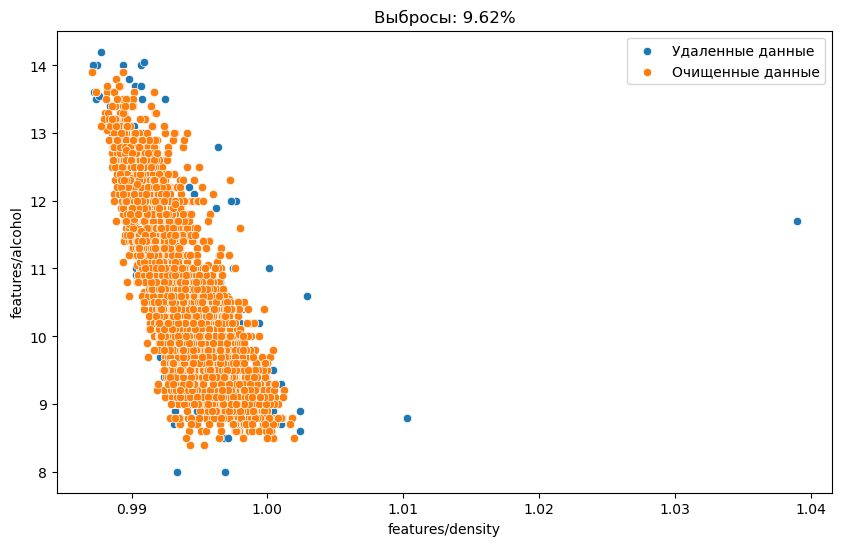

In [6]:
import seaborn as sns

z_scores = (data - data.mean()) / data.std()

abs_z_scores = np.abs(z_scores)

for threshold in np.arange(2.0, 3.5, 0.1):
    outlier_indices = (abs_z_scores > threshold).any(axis=1)
    
    outlier_percentage = sum(outlier_indices) / len(data) * 100
    
    if 5 <= outlier_percentage <= 10:
        cleaned_data = data[~outlier_indices]
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=_1, y=_2, data=data, label='Удаленные данные')
        sns.scatterplot(x=_1, y=_2, data=cleaned_data, label='Очищенные данные')
        plt.xlabel(_1)
        plt.ylabel(_2)
        plt.title(f'Выбросы: {outlier_percentage:.2f}%')
        plt.legend()
        plt.show()
        break

# 3.	Выполните стандартизацию независимого признака и масштабирование на интервал [-1, 1] зависимого признака. Решите задачи линейной регрессии и полиномиальной регрессии для степени полинома, указанной в индивидуальном задании, при помощи нейронных сетей с одним нейроном и оцените качество полученных моделей по показателю, указанному в #индивидуальном задании. Отследите обучение нейронных сетей, изменяя, при необходимости, гиперпараметры (функцию потерь, оптимизатор, шаг обучения и т.п.) или применяя регуляризацию.

In [7]:
n = 5

score = mean_squared_error

data = data.dropna()

In [8]:
X = data[[_1]].values
y = data[[_2]].values

scaler_X = StandardScaler()
data[[_1]] = scaler_X.fit_transform(data[[_1]])
X = data[_1].values

scaler_y = MinMaxScaler(feature_range=(-1, 1))
data[[_2]] = scaler_X.fit_transform(data[[_2]])
y = data[_2].values

In [9]:
x1 = X.reshape(-1,1)
x2 = np.hstack([x1 ** i for i in range(1, n + 1)])

In [10]:
reg1_model = tf.keras.Sequential( [ tf.keras.layers.Dense(1, input_shape=(1,)) ] )
reg1_model.compile(
    loss=tf.keras.losses.mean_absolute_error,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.25),
    metrics=['mean_absolute_error']
)

history1 = reg1_model.fit(x1, y, epochs=100,verbose=False,validation_split = 0.3) 

print(f'{score.__name__}', score(y, reg1_model.predict(x1)))

154/154 [==============================] - 0s 2ms/step
mean_squared_error 0.39555675


In [11]:
reg2_model = tf.keras.Sequential([
    tf.keras.Input(shape=(n,)),
    tf.keras.layers.Dense(units=1)
])

reg2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history2 = reg2_model.fit(
    x2, y, 
    epochs=100,
    verbose=False,
    validation_split = 0.3)

print(f'{score.__name__}', score(y, reg2_model.predict(x2)))

154/154 [==============================] - 0s 2ms/step
mean_squared_error 16513953.0


# 4.	Постройте кривые обучения для построенных нейронных сетей с зависимостью от количества эпох. На визуализации создайте легенду.

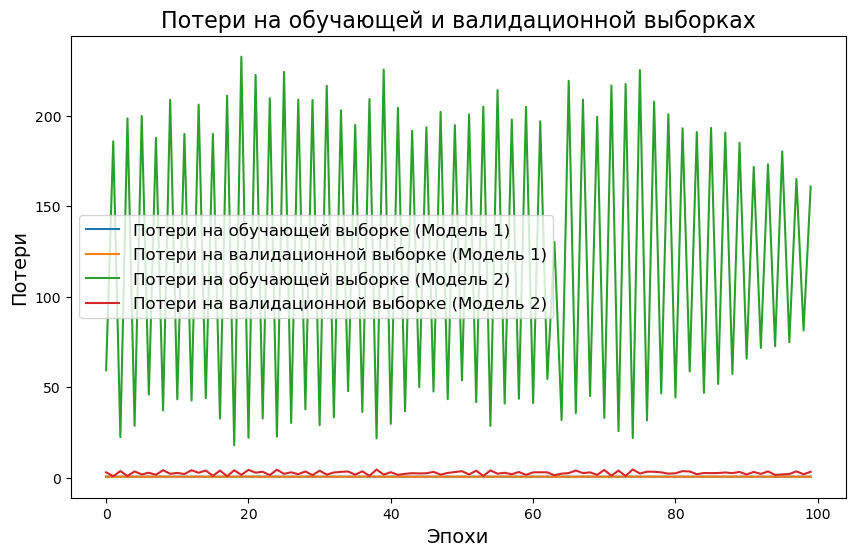

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'], label='Потери на обучающей выборке (Модель 1)')
plt.plot(history1.history['val_loss'], label='Потери на валидационной выборке (Модель 1)')
plt.plot(history2.history['loss'], label='Потери на обучающей выборке (Модель 2)')
plt.plot(history2.history['val_loss'], label='Потери на валидационной выборке (Модель 2)')

plt.title('Потери на обучающей и валидационной выборках', fontsize=16)
plt.xlabel('Эпохи', fontsize=14)
plt.ylabel('Потери', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 5.	Визуализируйте точки набора данных на плоскости в виде диаграммы рассеяния (ось X – независимый признак, ось Y – зависимый признак), а также линии линейной и полиномиальной регрессий (другими цветами), подписывая оси и рисунок и создавая легенду.

154/154 [==============================] - 0s 2ms/step


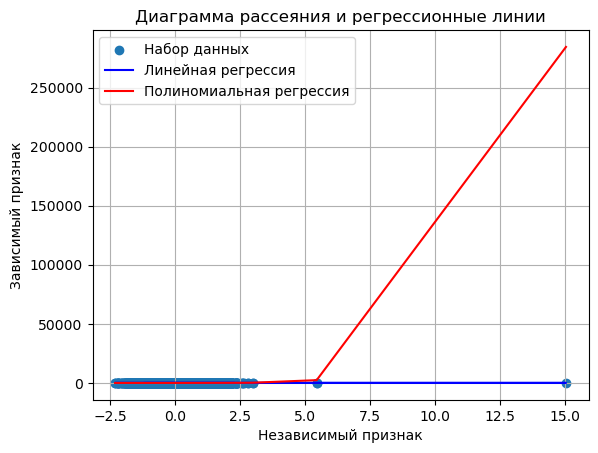

In [13]:
plt.scatter(X, y, label='Набор данных')

plt.plot(x1, reg1_model.predict(x1), color='blue', label='Линейная регрессия')

plt.plot(np.sort(X), reg2_model.predict(x2)[np.argsort(X)], color='red', label='Полиномиальная регрессия')

plt.xlabel('Независимый признак')
plt.ylabel('Зависимый признак')
plt.title('Диаграмма рассеяния и регрессионные линии')
plt.legend()

plt.grid()
plt.show()

# 6. Определите в исходном наборе данных признак (отличный от независимого и #зависимого признаков), принимающий непрерывные значения и имеющий свойства, указанные в индивидуальном задании.

In [14]:
columns_to_keep = [col for col in data.columns if data[col].nunique() > 20]
data = data[columns_to_keep]

In [15]:
correlations = data.drop([_2], axis=1).corrwith(data[_1])

_3 = correlations.idxmin()

print(f"Признак с минимальной корреляцией с независимой переменной ({_2}): {_3}")

Признак с минимальной корреляцией с независимой переменной (features/alcohol): features/pH


# 7.	Стандартизуйте #этот признак и визуализируйте его в соответствии с индивидуальным заданием.

In [16]:
selected_feature_values = data[_3].values
scaler_selected_feature = StandardScaler()
data[_3] = scaler_selected_feature.fit_transform(selected_feature_values.reshape(-1, 1))

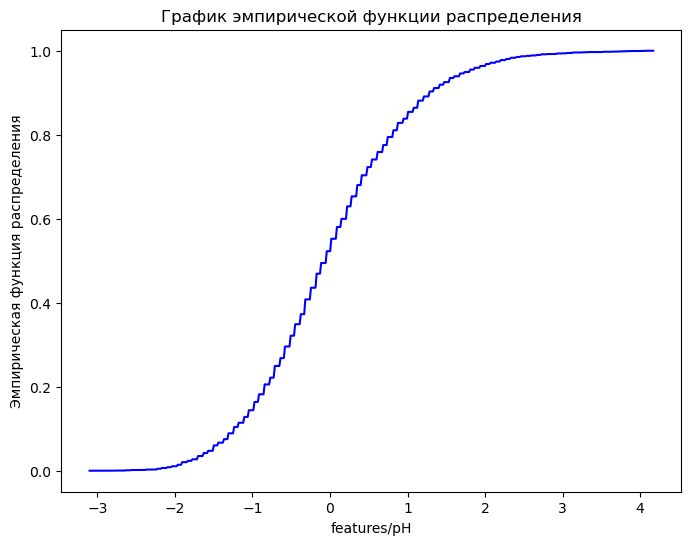

In [17]:
f = _3
def ECDF(data, x):
    counter = 0
    for v in data:
        if v <= x:
            counter += 1
    return counter / len(data)

samples = data[f]
npoints = 500
dx = (samples.max() - samples.min()) / npoints

xlist = [samples.min() + dx*i for i in range(npoints)]
ylist = [ECDF(samples, x) for x in xlist]

df_ECDF = pd.DataFrame(ylist, columns=[f], index=xlist)

plt.figure(figsize=(8, 6))
plt.plot(df_ECDF.index, df_ECDF[f], color='blue')
plt.xlabel(f)
plt.ylabel('Эмпирическая функция распределения')
plt.title('График эмпирической функции распределения')

plt.show()

# 8.	Сформируйте набор входных данных из двух стандартизованных признаков набора данных (независимый признак и определенный признак), постройте нейронную сеть (нелинейный регресор) с количеством скрытых слоев, количеством нейронов и функцией активации, # указанными в индивидуальном задании, и одним нейроном в выходном слое и обучите ее на наборе данных из двух признаков и отклика. Отследите обучение нейронной сети, изменяя, при необходимости, гиперпараметры (функцию потерь, оптимизатор, шаг обучения и т.п.) или применяя регуляризацию.

In [18]:
X = data[[_1,_2,_3]].dropna()

y = X[_2]
X = X[[_1,_3]]

In [19]:
num_hidden_layers = 3
num_neurons_per_layer = 128
activation_function = 'relu'

deep_model = tf.keras.Sequential()
for _ in range(num_hidden_layers):
    deep_model.add(tf.keras.layers.Dense(units=num_neurons_per_layer, activation=activation_function))
deep_model.add(tf.keras.layers.Dense(units=1))

deep_model.compile(loss='mse')

history = deep_model.fit(
    X, y, 
    epochs=100,
    verbose=False,
    validation_split=0.3)

deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
_________________________________________________________________


# 9.	Визуализируйте набор данных в виде диаграммы рассеяния и прогноз нейронной сети в виде поверхности в трехмерном пространстве, подписывая оси и рисунок.

82/82 [==============================] - 0s 2ms/step


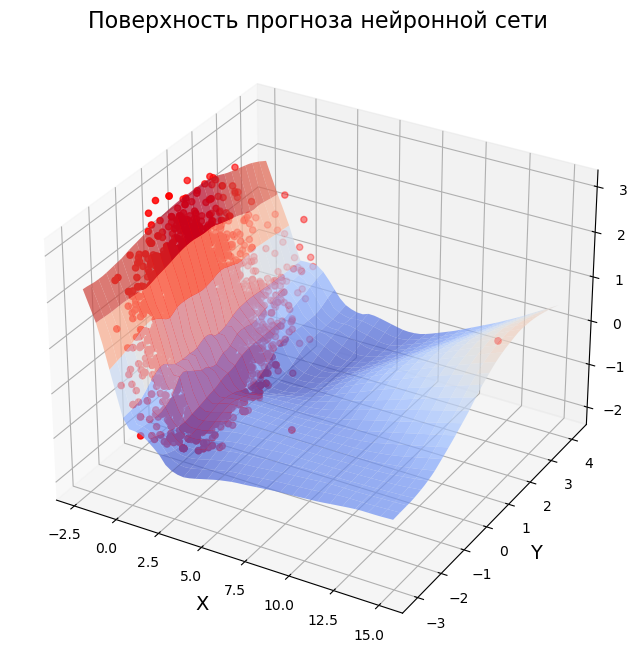

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

xs = X.values[:,0]
ys = X.values[:,1]
zs = y

n_plot = 51
x_plot = np.linspace(np.min(xs), np.max(xs), n_plot)
y_plot = np.linspace(np.min(ys), np.max(ys), n_plot)
x_mesh, y_mesh = np.meshgrid(x_plot, y_plot)
xy_2 = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])
z_mesh = deep_model.predict(xy_2).reshape(x_mesh.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap=cm.coolwarm, alpha=0.7)

ax.scatter(xs, ys, zs, color='red')

ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.set_zlabel('Z', fontsize=14)
ax.set_title('Поверхность прогноза нейронной сети', fontsize=16)

plt.show()

# 10.	Разбейте набор данных из двух признаков и отклика на обучающую и тестовую выборки и постройте кривые обучения для заданного показателя качества в зависимости от количества точек в обучающей выборке, подписывая оси и рисунок и создавая легенду.

31/31 [==============================] - 0s 2ms/step
--> 11  done
31/31 [==============================] - 0s 2ms/step
--> 311  done
31/31 [==============================] - 0s 2ms/step
--> 611  done
31/31 [==============================] - 0s 2ms/step
--> 911  done
31/31 [==============================] - 0s 2ms/step
--> 1211  done
31/31 [==============================] - 0s 3ms/step
--> 1511  done
31/31 [==============================] - 0s 2ms/step
--> 1811  done
31/31 [==============================] - 0s 3ms/step
--> 2111  done
31/31 [==============================] - 0s 2ms/step
--> 2411  done
31/31 [==============================] - 0s 3ms/step
--> 2711  done
31/31 [==============================] - 0s 2ms/step
--> 3011  done
31/31 [==============================] - 0s 2ms/step
--> 3311  done
31/31 [==============================] - 0s 2ms/step
--> 3611  done
31/31 [==============================] - 0s 3ms/step
--> 3911  done


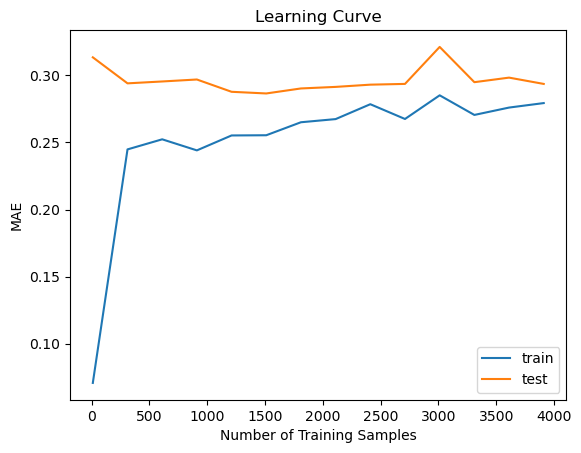

In [21]:
def train_test_split(X, y, test_ratio=0.2, seed=None):
    """возвращает X_train, X_test, y_train, y_test"""
    assert X.shape[0] == y.shape[0], \
        "Размер X должен быть равен размеру y"
    assert 0.0 <= test_ratio <= 1.0, \
        "Неверное значение test_ratio"
    if seed:
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))
    test_size = int(len(X) * test_ratio)
    test_indexes = shuffled_indexes[:test_size]
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes]
    y_train = y[train_indexes]
    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values)

train_score = []
test_score = []

for i in range(11, len(X_train), 300):
    deep_model.compile(loss='mse')
    deep_model.fit(X_train[:i], y_train[:i], epochs=10, verbose=0)
    
    y_train_predict = deep_model.predict(X_train[:i])
    train_score.append(score(y_train[:i], y_train_predict))
    
    y_test_predict = deep_model.predict(X_test)
    test_score.append(score(y_test, y_test_predict))
    
    print('-->', i, ' done')

plt.plot([i for i in range(11, len(X_train), 300)], train_score, label="train")
plt.plot([i for i in range(11, len(X_train), 300)], test_score, label="test")
plt.title('Learning Curve')
plt.xlabel('Number of Training Samples')
plt.ylabel('MAE')
plt.legend()
plt.show()